In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1. 生成数据集

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 1.1523, -0.2654]) 
label: tensor([7.4183])


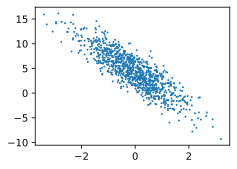

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2. 读取数据集

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8323,  0.1120],
        [-0.6453,  0.7532],
        [ 0.5613, -0.3309],
        [-0.1919, -2.5125],
        [ 0.5467, -0.6374],
        [ 0.9637,  1.3103],
        [-0.4472,  1.4337],
        [ 0.6333,  0.8502],
        [-0.7209, -1.1852],
        [ 1.8200,  1.0496]]) 
 tensor([[ 2.1600],
        [ 0.3565],
        [ 6.4543],
        [12.3595],
        [ 7.4718],
        [ 1.6614],
        [-1.5681],
        [ 2.5955],
        [ 6.7819],
        [ 4.2675]])


### 3.2.3. 初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # torch.zeros(size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4. 定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 3.2.5. 定义损失函数

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6. 定义优化算法

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7. 训练

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030338
epoch 2, loss 0.000112
epoch 3, loss 0.000054


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-3.6716e-05,  2.6894e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([8.4877e-05], grad_fn=<RsubBackward1>)


### Practice
### 问题解析与解答

---

#### **1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？**

**答：**

如果将权重初始化为零：

- 对于 **线性模型**（如线性回归或逻辑回归），算法仍然有效，因为每个权重的梯度计算是独立的，权重会逐步调整到正确的值。
- 对于 **神经网络**，算法将 **失效**。这是因为在反向传播中，所有权重的梯度会完全相同，导致权重始终保持对称，网络无法学习到有用的特征。

解决方案是使用随机初始化方法（如 Xavier 初始化或 He 初始化），以打破对称性。

---

#### **2. 假设图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗？**

**答：**

**答：可以。**

- 自动微分可以高效地计算模型的参数梯度，从而用于优化模型。
- 在建立模型时，可以利用深度学习框架（如 PyTorch 或 TensorFlow）自动计算损失函数关于模型参数的梯度，并通过优化器（如 SGD、Adam）更新参数。

---

#### **3. 能基于普朗克定律使用光谱能量密度来确定物体的温度吗？**

**答：**

**答：可以。**

普朗克定律的公式为：

$$
E(\lambda, T) = \frac{2hc^2}{\lambda^5} \cdot \frac{1}{e^{\frac{hc}{\lambda k_B T}} - 1}
$$

- $E(\lambda, T)$ 表示波长 $\lambda$ 下的光谱能量密度。
- $T$ 是物体的绝对温度。
- $h$ 为普朗克常数，$c$ 为光速，$k_B$ 为玻尔兹曼常数。

通过测量光谱能量密度 $E(\lambda, T)$，可以利用最小二乘或其他拟合方法，反推出温度 $T$。

---

#### **4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？**

**答：**

**问题：**

- **内存开销大**：计算二阶导数需要存储更高阶的导数值，会占用大量内存。
- **数值不稳定性**：二阶导数的计算可能导致数值误差积累，尤其是在深度网络中。
- **计算复杂度高**：相比一阶导数，计算二阶导数的复杂度更高，可能会导致训练速度变慢。

**解决方法：**

- **稀疏计算**：仅计算需要的部分二阶导数（如 Hessian 矩阵的对角线）。
- **近似方法**：使用数值方法（如有限差分法）近似计算二阶导数。
- **自动微分框架优化**：利用框架（如 PyTorch 的 `torch.autograd.functional.hessian`）高效地计算 Hessian 矩阵。

---

#### **5. 为什么在 `squared_loss` 函数中需要使用 `reshape` 函数？**

**答：**

在 `squared_loss` 函数中，通常需要将预测值和真实值的形状调整为一致（如列向量或行向量），以便执行逐元素运算（如减法或平方）。

例如：

$$
\text{squared\_loss}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

如果 $y$ 和 $\hat{y}$ 的形状不一致，可能会导致广播错误。因此，使用 `reshape` 函数确保它们的形状相同。

---

#### **6. 尝试使用不同的学习率，观察损失函数值下降的快慢。**

**答：**

- **学习率过小**：损失函数下降缓慢，训练时间增加。
- **学习率过大**：可能导致损失函数震荡，甚至发散。
- **学习率合适**：损失函数快速下降，收敛到较优解。

可以通过 **学习率调度器** 或 **自适应优化器**（如 Adam、RMSprop）动态调整学习率，提升训练效果。

---

#### **7. 如果样本个数不能被批量大小整除，`data_iter` 函数的行为会有什么变化？**

**答：**

如果样本个数不能被批量大小整除，`data_iter` 函数在最后一个批次中通常会包含剩余的样本，批量大小会小于设定的值。

例如：

- 数据集有 103 个样本，批量大小为 20。
- 前 5 个批次大小为 20，最后一个批次大小为 3。

为了避免这种情况，可以通过以下方法处理：

1. **丢弃不足的样本**：忽略最后一个小批次。
2. **补全样本**：对最后一个批次进行零填充（padding）。
3. **动态调整批次大小**：允许最后一个批次的大小小于设定值。

---